![konya](images/ktun.png)
<h4><center>T.C.<br>KONYA TEKNİK ÜNİVERSİTESİ<br>LİSANSÜSTÜ EĞİTİM ENSTİTÜSÜ</center><h4>

<strong><center>Dental X-ray Image Analysis</center></strong>
<strong><center>Cephalometric Keypoints Detection using CNN Run</center></strong><br>

### Automated Detection and Analysis for Diagnosis in Cephalometric X-ray Image Using Convolutional Neural Network

## Display of the points got from test images using the trained Convolutional Neural Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform, img_as_float
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models # add models to the list
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.utils import make_grid
import time
import random
import csv

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In C:\Users\Flayiva_01\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Flayiva_01\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Flayiva_01\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [14]:
# Take a look at one of the image samples and labels

#NOTE: THE IMAGE FOLDERS HAS BEEN MODIFIED AND SEPERATED INTO TRAIN AND TEST FOLDERS SETS
SAMPLE_PATH = "data/RawImage/Test1Data/153.bmp"
TXT_PATH = "logs/test1/ensemble/Ensemble/predictions/1.csv"
TXT_REAL_PATH = "data/AnnotationsByMD/400_senior/153.txt"


# import sample image
img = io.imread(SAMPLE_PATH, as_gray=True)
img

array([[1.        , 1.        , 1.        , ..., 0.99607843, 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.99607843, 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.99607843, 1.        ,
        0.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.7372549 , 0.78823529,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.78039216, 0.77254902,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00784314,
        0.        ]])

In [5]:
TXT_PATH

'logs/test1/ensemble/Ensemble/predictions/1.csv'

In [6]:
img.shape

(2400, 1935)

In [7]:
# with open(TXT_PATH) as csvfile:
#      print("\n".join([x.split(",")[1] for x in file1.read().split("\n")]))
def merge(list1, list2): 
      
    merged_list = [tuple([int(float(list1[i])),int(float(list2[i]))]) for i in range(0, len(list1))] 
    return merged_list 

In [8]:
def extract_cordinate_from_cvs(path):
    with open(path) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        print(readCSV)
        x_cordinates = []
        y_cordinates = []
        index = 0
        for row in readCSV:
            print(row)
            if(index == 1):
                y_cords = row[21:40]
                x_cords = row[40:]
                print(y_cords)
                print(merge(x_cords, y_cords))
                cordinates = merge(x_cords, y_cords)
                break
            index +=1
    return cordinates

In [9]:
extract_cordinate_from_cvs(TXT_PATH)

['', 'file', '0_act', '1_act', '2_act', '3_act', '4_act', '5_act', '6_act', '7_act', '8_act', '9_act', '10_act', '11_act', '12_act', '13_act', '14_act', '15_act', '16_act', '17_act', '18_act', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x']
['0', '151.bmp', '8.08469009399414', '7.935091972351074', '8.000539779663086', '5.837769508361816', '6.557595252990723', '7.671187400817871', '7.917133331298828', '9.194160461425781', '8.193755149841309', '8.342549324035645', '7.5287065505981445', '8.023168563842773', '9.051240921020508', '8.56475830078125', '8.040345191955566', '8.251579284667969', '8.208197593688965', '7.763049125671387', '7.562407493591309', '1050.0', '1050.0', '1294.0', '1219.0', '1575.0', '1894.0', '2006.0', '2062.0', '2044.0', '1753.0', '1762.0'

[(854, 1050),
 (1429, 1050),
 (1300, 1294),
 (627, 1219),
 (1368, 1575),
 (1308, 1894),
 (1285, 2006),
 (1240, 2062),
 (1270, 2044),
 (733, 1753),
 (1368, 1762),
 (1383, 1762),
 (1527, 1706),
 (1474, 1866),
 (1459, 1575),
 (1368, 2091),
 (960, 1453),
 (1406, 1519),
 (665, 1331)]

In [13]:
def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:19]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

In [15]:
extract_labels_from_txt(TXT_REAL_PATH)

[(855, 1088),
 (1392, 963),
 (1325, 1177),
 (648, 1219),
 (1468, 1523),
 (1435, 1784),
 (1452, 1959),
 (1414, 2017),
 (1448, 1995),
 (822, 1806),
 (1455, 1652),
 (1502, 1702),
 (1599, 1620),
 (1584, 1756),
 (1531, 1483),
 (1540, 2012),
 (1057, 1471),
 (1444, 1441),
 (727, 1426)]

In [16]:
ORIG_IMAGE_X = 1935
ORIG_IMAGE_Y = 2400
PIXELS_PER_MM = 10
N_LANDMARKS = 19

# (2400, 1935)

In [84]:
def print_image(img,coords_raw):
    plt.rcParams["figure.figsize"] = [32,18]
    plt.style.use(['dark_background'])
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 1, 1)
    ax1.imshow(img, cmap="gray")
    # also plot resized image for later 
    orig_y, orig_x = img.shape[:2]
    SCALE = 9.375

    # for rescale, use same target for both x&y axis
    rescaled_img = transform.resize(img,(orig_y/9.375,orig_y/9.375))
    ax2.imshow(rescaled_img, cmap="gray")

    for c in coords_raw:
        # add patches to original image
        # could also just plt.scatter() but less control then
        ax1.add_patch(plt.Circle(c, 5, color='r')) 
        # and rescaled marks to resized images
        x,y = c
        x = int(x*(orig_y*1.0/orig_x)/SCALE)
        y = int(y/SCALE)
        ax2.add_patch(plt.Circle((x,y), 1, color='r')) 

    plt.show()

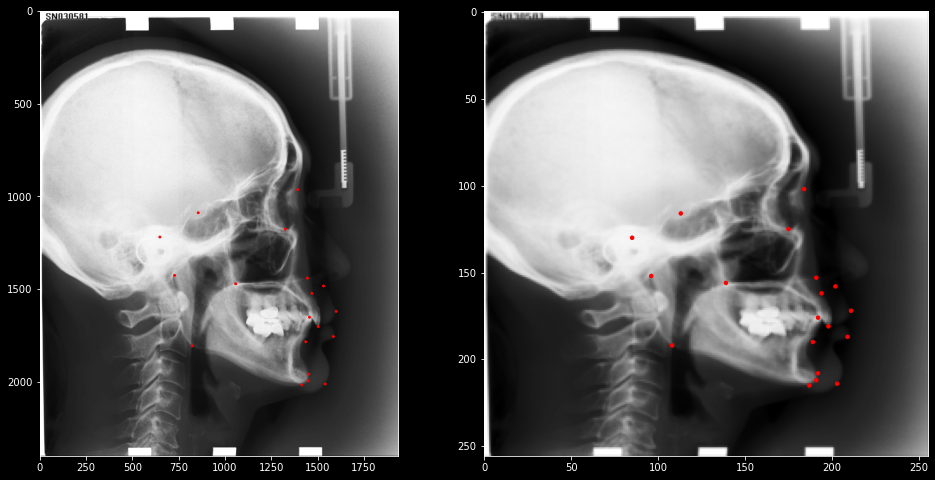

In [85]:
print_image(img, extract_labels_from_txt(TXT_REAL_PATH))